In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

In [18]:
def photo_colormap(image_path,levels,allow_discontinuities=None):
           
    # Open the image
    img       = Image.open(image_path)
    
    # Convert the image to a numpy array
    img_array = np.array(img)

    # Filter for black and white
    valid     = ((img_array[:, :, 0] > 0) & (img_array[:, :, 1] > 0) & (img_array[:, :, 2] > 0) &
                  (img_array[:, :, 0] < 255) & (img_array[:, :, 1] < 255) & (img_array[:, :, 2] < 255))

    rgb_data  = img_array[valid]

    # Perform PCA
    pca       = PCA(n_components=3)
    pca.fit(rgb_data)

    # Project the original data onto the new coordinate system
    transformed_data = np.dot(rgb_data, pca.components_.T)

    # Create an independent variable for the first PC
    PC_1 = np.linspace(np.min(transformed_data[:,0]),np.max(transformed_data[:,0]),levels)
    PC_2 = []
    PC_3 = []
    
    width=(np.max(transformed_data[:,0])-np.min(transformed_data[:,0]))/levels
    
    # Walk along first PC and compute medians for the second and third PC
    for step in range(len(PC_1)):
        mask = np.where((transformed_data[:,0] < PC_1[step]+width) & (transformed_data[:,0] > PC_1[step]-width))
        PC_2 = np.append(PC_2,np.nanmedian(transformed_data[mask,1]))
        PC_3 = np.append(PC_3,np.nanmedian(transformed_data[mask,2]))
        
    # if discontinuities are not allowed
    if allow_discontinuities is None:  
        
        # Do a polynomial fit to the second and third PC
        PC_2_fit = np.polyval(np.polyfit(PC_1,PC_2,8),PC_1)
        PC_3_fit = np.polyval(np.polyfit(PC_1,PC_3,8),PC_1)

        # Create the color vector and transform back to the RGB-space
        PC_color_vector = np.array([PC_1,PC_2_fit,PC_3_fit])
        color_vector    = np.dot(PC_color_vector.T, pca.components_)
        
    # if discontinuities are allowed
    else:  
        
        # Create the color vector and transform back to the RGB-space
        PC_color_vector = np.array([PC_1,PC_2,PC_3])
        color_vector    = np.dot(PC_color_vector.T, pca.components_)

    # Filter values smaller than 0 and larger than 255
    valid = np.where((color_vector[:,0]>=0) & (color_vector[:,1]>=0) & (color_vector[:,2]>=0) &
        (color_vector[:,0]<=255) & (color_vector[:,1]<=255) & (color_vector[:,2]<=255))
    norm  = np.squeeze(color_vector[valid,:])
    norm /= 255

    # Create colormap
    custom_cmap = ListedColormap(norm)

    return custom_cmap

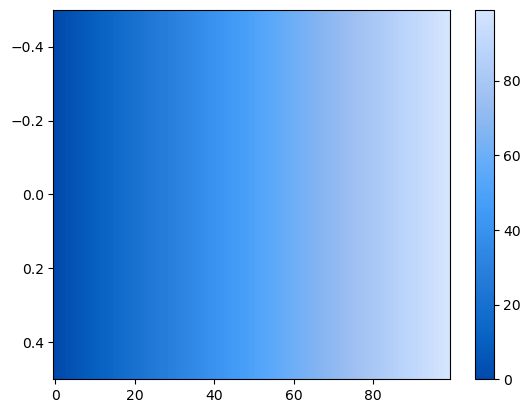

In [74]:
image_path=r'C:\Users\reic_re\Downloads\blue.jpg' 
custom_cmap=photo_colormap(image_path,200)
plt.imshow([[i for i in range(100)]], cmap=custom_cmap, aspect='auto')
plt.colorbar()

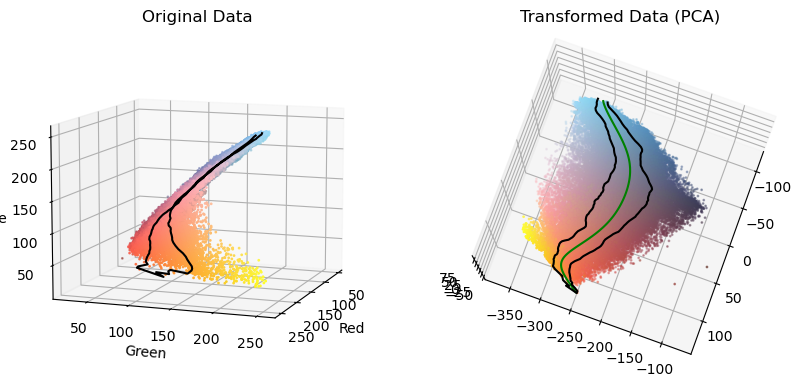

In [55]:
# Plot original and transformed data
fig = plt.figure(figsize=(10, 5))

# Plot original data
ax1 = fig.add_subplot(121, projection='3d')

# Scatter plot
ax1.scatter(rgb_data[:, 0], rgb_data[:, 1], rgb_data[:, 2], c=rgb_data / 255, s=1)
ax1.plot(255*norm[:,0],255*norm[:,1],255*norm[:,2],color='k',zorder=10)

# Set labels
ax1.set_xlabel('Red')
ax1.set_ylabel('Green')
ax1.set_zlabel('Blue')

ax1.set_title('Original Data')
ax1.view_init(elev=10, azim=20) 

# Plot transformed data
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], c=rgb_data / 255, s=1)
ax2.plot(PC_color_vector_1.T[:,0],PC_color_vector_1.T[:,1],PC_color_vector_1.T[:,2],color='green',zorder=10)
ax2.plot(PC_color_vector.T[:,0],PC_color_vector.T[:,1],PC_color_vector.T[:,2],color='k',zorder=10)
ax2.set_title('Transformed Data (PCA)')
ax2.view_init(elev=80, azim=20)

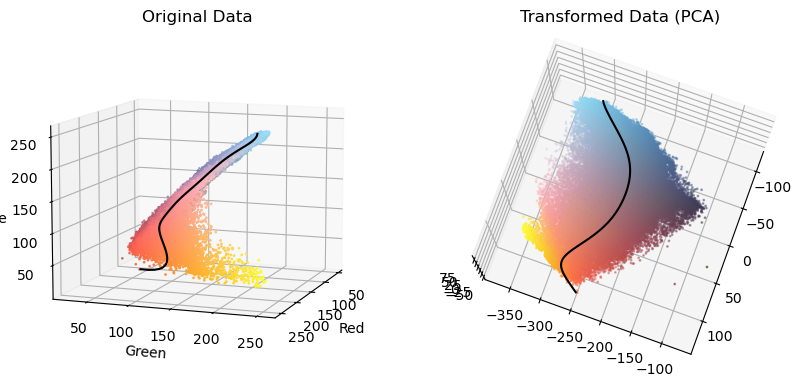

In [29]:
# Open the image
img = Image.open(image_path)  # Replace 'your_image.jpg' with the path to your image

# Convert the image to a numpy array
img_array = np.array(img)
img_array = img_array[::10,::10,:]

# Reshape and standardize RGB data
rgb_data = img_array.reshape((-1, 3))
valid=np.where((rgb_data[:,0]>0) & (rgb_data[:,1]>0) & (rgb_data[:,2]>0) &
               (rgb_data[:,0]<255) & (rgb_data[:,1]<255) & (rgb_data[:,2]<255))
rgb_data = np.squeeze(rgb_data[valid,:])

# Perform PCA
pca = PCA(n_components=3)
pca.fit(rgb_data)

# Get the principal components
components = pca.components_

# Project the original data onto the new coordinate system
transformed_data = np.dot(rgb_data, components.T)

levels=100
axis_1=np.linspace(np.min(transformed_data[:,0]),np.max(transformed_data[:,0]),levels)
axis_2=[]
axis_3=[]
width=(np.max(transformed_data[:,0])-np.min(transformed_data[:,0]))/levels
for step in range(len(axis_1)):
    mask=np.where((transformed_data[:,0] < axis_1[step]+width) & (transformed_data[:,0] > axis_1[step]-width))
    axis_2=np.append(axis_2,np.nanmedian(transformed_data[mask,1]))
    axis_3=np.append(axis_3,np.nanmedian(transformed_data[mask,2]))
    
result_2= np.polyfit(axis_1,axis_2,8)
axis_2_fit= np.polyval(result_2,axis_1)

result_3= np.polyfit(axis_1,axis_3,8)
axis_3_fit= np.polyval(result_3,axis_1)


new_color_vector=np.array([axis_1,axis_2_fit,axis_3_fit])
back_transformed_data = np.dot(new_color_vector.T, components)

# Create colormap
valid=np.where((back_transformed_data[:,0]>=0) & (back_transformed_data[:,1]>=0) & (back_transformed_data[:,2]>=0) &
    (back_transformed_data[:,0]<=255) & (back_transformed_data[:,1]<=255) & (back_transformed_data[:,2]<=255))
norm = np.squeeze(back_transformed_data[valid,:])
#norm=back_transformed_data-np.min(back_transformed_data)
#norm/=np.max(norm)
#norm*=255

# Plot original and transformed data
fig = plt.figure(figsize=(10, 5))

# Plot original data
ax1 = fig.add_subplot(121, projection='3d')

# Scatter plot
ax1.scatter(rgb_data[:, 0], rgb_data[:, 1], rgb_data[:, 2], c=rgb_data / 255, s=1)
ax1.plot(norm[:,0],norm[:,1],norm[:,2],color='k',zorder=10)

# Set labels
ax1.set_xlabel('Red')
ax1.set_ylabel('Green')
ax1.set_zlabel('Blue')

ax1.set_title('Original Data')
ax1.view_init(elev=10, azim=20) 

# Plot transformed data
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], c=rgb_data / 255, s=1)
ax2.plot(new_color_vector.T[:,0],new_color_vector.T[:,1],new_color_vector.T[:,2],color='k',zorder=10)
ax2.set_title('Transformed Data (PCA)')
ax2.view_init(elev=80, azim=20)